##### **Project Type**    - Machine Learning
##### **Contribution**    - Individual
##### **Team Member 1 -** - Lalit Kumar Harode

This RAVDESS dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

# Loading Libraries

In [ ]:
import pandas as pd
import os

import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np

# Loading a audio

In [ ]:
x, sr = librosa.load('../input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav')
sf.write('stereo_file.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

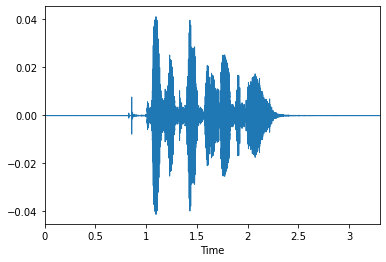

In [ ]:
librosa.display.waveplot(x,sr=sr)

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

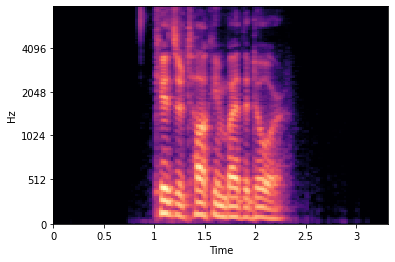

In [ ]:
spectrogram=librosa.feature.melspectrogram(y=x,sr=sr,n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');

# Feature Preprocessing

The speech signal usually
include many parts of silence. The silence
signal is not important because it does not contain useful
information.

**Zero crossing rate** is a measure of number of times
in a given time interval such that the amplitude
of the speech signals passes through a value of
zero.

In [ ]:
# Data Preprocessing
# Silence Removal
# Taking window of 4 and if number of zero croasigs are greater than 2,we dont include amplitudes in this wondow
def zero_crossing(x):
    zero_crossings=[]
    silence_removed=[]
    silence_removed=np.array(silence_removed)
    for i  in range(1,len(x)):
        # detecting zero crossing
        if(x[i-1]<=0 and x[i]>0):
            zero_crossings.append(1)
        else:
            zero_crossings.append(0)
    for i in range(len(zero_crossings)-3):
        zeros=np.sum(zero_crossings[4*i:4*(i+1)])
        #print(zeros)
        zeros=4-zeros
        if(zeros>2):
            silence_removed=np.concatenate((silence_removed,np.array(x[4*i:4*(i+1)])))
    print("Before Silence Removal : ",len(x),"\nAfter Silence Removal : ",len(silence_removed))
    return silence_removed

In [ ]:
silence_removed=zero_crossing(x)

Before Silence Removal :  72838 
After Silence Removal :  54334


In [ ]:
Audio(data=x, rate=sr)

In [ ]:
Audio(data=silence_removed, rate=sr)

Both silence removed and normal audio wave sounds similar.

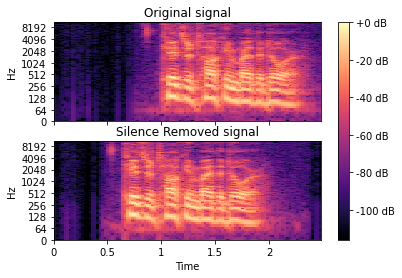

In [ ]:
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max, top_db=None)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(silence_removed)), ref=np.max, top_db=None)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Silence Removed signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")

The **pre-emphasis** of the speech
signal is the most important steps of
preprocessing at high frequency. It finds
comparable amplitude by passing the speech signal through a high-pass filter (FIR).

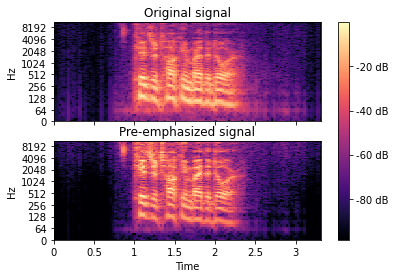

In [ ]:
#Pre-emphasis
y_filt = librosa.effects.preemphasis(x)
# and plot the results for comparison
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max, top_db=None)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max, top_db=None)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Pre-emphasized signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")

**Normalization** is a strategy for modifying
the volume of sound to a standard level.

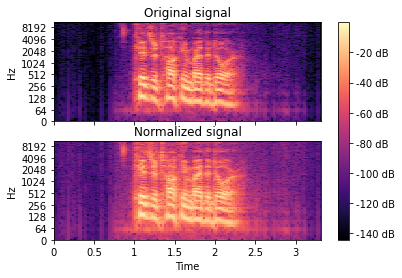

In [ ]:
#Normalization
x_norm=x/max(x)
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max, top_db=None)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(x_norm)), ref=np.max, top_db=None)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Normalized signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
def preprocessing(file):
    X,sample_rate = librosa.load(file)
    # zero crossing
    #silence_removed=zero_crossing(X)
    # Pre emphasis
    y_filt = librosa.effects.preemphasis(X)
    # normalization
    #x_norm=y_filt/max(y_filt)
    return y_filt,sample_rate

# Feature Extraction

In [ ]:
# All the types of emotions that are present
emotions_all={
    '01' : 'neutral',
    '02' : 'calm' ,
    '03' : 'happy' ,
    '04' : 'sad' ,
    '05' : 'angry',
    '06' : 'fearful' ,
    '07' : 'disgust',
    '08' : 'surprised'
}

In [ ]:
# Feature extraction using librosa a python package for audio analysis
# Chroma features

def feature_extraction(X,sample_rate):
    result = np.array([])

    # chroma stft: Compute a chromagram from a waveform or power spectrum
    stft = np.abs(librosa.stft(X))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # mfcc: Mel-frequency cepstral coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # melspectogram: Compute a mel-scaled spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))

    return result

In [ ]:
from glob import glob
files_audio = glob('/kaggle/input/ravdess-emotional-speech-audio'+'/*/*.wav')

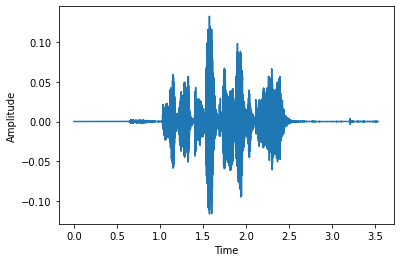

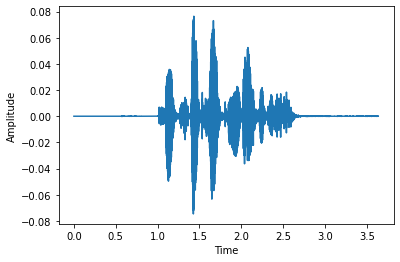

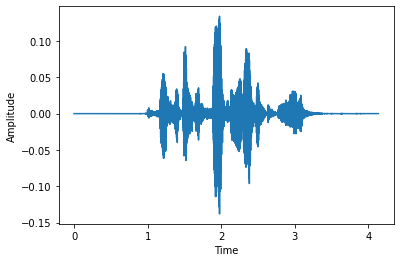

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    audio,sfreq = librosa.load(files_audio[i])
    time = np.arange(0,len(audio))/sfreq
    fig,ax = plt.subplots()
    ax.plot(time,audio)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

In [ ]:
# Read File name identifiers and load data values

x,y=[],[]
# Considered the following emotions
emotions=['happy','sad','angry','fearful','disgust']

from IPython.display import clear_output
e = set()

for file in files_audio:
        clear_output(wait=True)
        file_name = file.split('/')[-1]
        emotion=emotions_all[file_name.split("-")[2]]
        if emotion not in emotions:
            continue
        e.add(file.split('/')[-2])
        # preprocessing audio data
        pre_speech=preprocessing(file)
        # feature extraction from audio
        feature=feature_extraction(pre_speech[0],pre_speech[1])
        print(e)
        x.append(feature)
        y.append(emotion)

{'Actor_18', 'Actor_23', 'Actor_12', 'Actor_11', 'Actor_04', 'Actor_13', 'Actor_02', 'Actor_17', 'Actor_19', 'Actor_07', 'Actor_03', 'Actor_08', 'Actor_01', 'Actor_20', 'Actor_06', 'Actor_22', 'Actor_24', 'Actor_16', 'Actor_05', 'Actor_10', 'Actor_09', 'Actor_21', 'Actor_14', 'Actor_15'}


In [ ]:
# features of audio
x = np.array(x)

<BarContainer object of 5 artists>

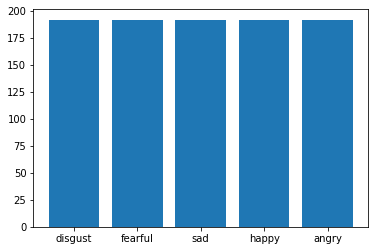

In [ ]:
from collections import Counter
target_count=pd.Series(Counter(y))
plt.bar(target_count.index,target_count)

In [ ]:
x.shape

(960, 160)

In [ ]:
len(y)

960

In [ ]:
# Encoding technique to handle categorical variables (Emotions)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Transform features by scaling each feature to given range
from sklearn.preprocessing import MinMaxScaler
scaler  =  MinMaxScaler()
x = scaler.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4,shuffle=True,stratify=y)

Decision Tree Classifier Models

In [ ]:
# XGBClassifier: Boosting algorithm based on gradient boosted decision trees algorithm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model=XGBClassifier()
#Training
model.fit(x_train,y_train)
#Prediction
y_pred1=model.predict(x_test)
print(accuracy_score(y_test,y_pred1))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6614583333333334


In [ ]:
# LGBMClassifier: Light gradient boosting
import lightgbm as lgb
#from lightgbm import LightGBMClassifier
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's multi_logloss: 0.301534	valid_0's multi_logloss: 1.05449
[40]	training's multi_logloss: 0.0649223	valid_0's multi_logloss: 0.97521
[60]	training's multi_logloss: 0.01417	valid_0's multi_logloss: 1.00065
[80]	training's multi_logloss: 0.00303504	valid_0's multi_logloss: 1.02415
[100]	training's multi_logloss: 0.000648649	valid_0's multi_logloss: 1.09583


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [ ]:
y_pred2=model.predict(x_test)
print(accuracy_score(y_test,y_pred2))

0.6979166666666666


In [ ]:
# RandomForestClassifier: Ensemble learning method for classification
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(x_train,y_train)
y_pred3=clf.predict(x_test)
print(accuracy_score(y_test,y_pred3))

0.4427083333333333


In [ ]:
# MLPClassifier: Multi layer perceptron classifier
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,100), learning_rate='adaptive', max_iter=1000)
model.fit(x_train,y_train)
y_pred4=model.predict(x_test)
print(accuracy_score(y_test,y_pred4))

0.6197916666666666


# Evaluation

Confusion Matrix

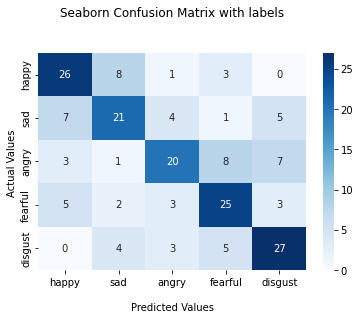

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred4, labels=[0,1,2,3,4])
import seaborn as sns

ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['happy','sad','angry','fearful','disgust'])
ax.yaxis.set_ticklabels(['happy','sad','angry','fearful','disgust'])

## Display the visualization of the Confusion Matrix.
plt.show()

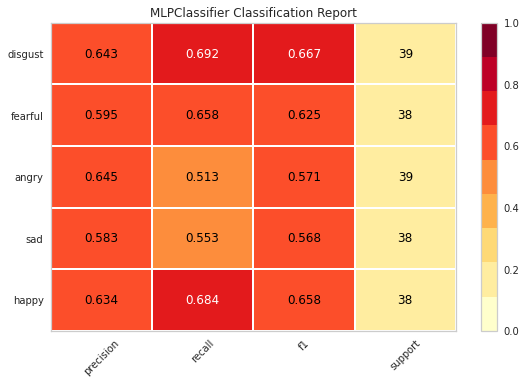

<AxesSubplot:title={'center':'MLPClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, classes=['happy','sad','angry','fearful','disgust'], support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()

# Testing

In [ ]:
emotions_all={
    '01' : 'neutral',
    '02' : 'calm' ,
    '03' : 'happy' ,
    '04' : 'sad' ,
    '05' : 'angry',
    '06' : 'fearful' ,
    '07' : 'disgust',
    '08' : 'surprised'
}

Loading a audio for testing

In [ ]:
test_audio, sr = librosa.load('../input/ravdess-emotional-speech-audio/Actor_04/03-01-04-01-02-02-04.wav')
Audio(data=test_audio, rate=sr)

In [ ]:
emotion=emotions_all['03-01-04-01-02-02-04'.split("-")[2]]

In [ ]:
# Actual Emotion
emotion

'sad'

In [ ]:
x=[]
y=[]
pre_speech=preprocessing('../input/ravdess-emotional-speech-audio/Actor_04/03-01-04-01-02-02-04.wav')
feature=feature_extraction(pre_speech[0],pre_speech[1])
x.append(feature)
y.append(emotion)

In [ ]:
pred=model.predict(x)

In [ ]:
# Predicted Emotion
label_encoder.inverse_transform(pred)

array(['sad'], dtype='<U7')